# Load Resilience of the WEST ICRH antenna 

In [1]:
# assume working in Jupyter Lab
%matplotlib inline 

%load_ext autoreload
%autoreload 2

In [2]:
import pywed as pw
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt 
plt.rcParams['figure.figsize'] = (10,6)

from control_room import *
from pulse_database import PulseDB

import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')

In [97]:
from control_room import get_sig, signals, smooth

In [6]:
import ICRH_FastData as fd

## Load Resilience from fast acquisition data

In [18]:
def eval_Xs(F0MHz):
    p1Xs = 0.000102
    p2Xs = -0.007769
    p3Xs = 0.724653
    p4Xs = -3.175984
    Xs   = p1Xs*F0MHz**3 + p2Xs*F0MHz**2 + p3Xs*F0MHz**1 + p4Xs
    return Xs

Calculating the VSWR. Reminder:
$\Gamma$ is the reflection coefficient 
$$
\Gamma = \frac{V_r}{V_f}
$$
and the voltage standing wave ratio is then
$$
VSWR 
    = \frac{1 + |\Gamma|}{1 - |\Gamma|}
    = \frac{1 + \sqrt{P_r/P_f}}{1 - \sqrt{P_r/P_f}}
$$


Calculating the coupling resistance. Reminder:
$$
Rc = X_s^2 \frac{P_f - P_r}{\sqrt{V_1^2 + V_2^2}}
$$

In [249]:
pulse = 53693
f0 = 48.2

data = fd.FastData(pulse, path='databases/Fast_Data/')


Reading file databases/Fast_Data\shot_53693_board_7851_1.dat
Reading file databases/Fast_Data\shot_53693_board_7851_3.dat
Reading file databases/Fast_Data\shot_53693_board_7851_5.dat
Reading file databases/Fast_Data\shot_53693_board_7853_0.dat
Reading file databases/Fast_Data\shot_53693_board_7853_2.dat
Reading file databases/Fast_Data\shot_53693_board_7853_4.dat


In [239]:
#data.Q2_amplitude = data.Q2_amplitude.query('index > 38.45*1e6 & index < 38.791*1e6')

In [180]:
PiG = smooth(data.Q2_amplitude['PiG'].values/10*1e3)
PiD = smooth(data.Q2_amplitude['PiD'].values/10*1e3)
PrG = smooth(data.Q2_amplitude['PrG'].values/10*1e3)
PrD = smooth(data.Q2_amplitude['PrD'].values/10*1e3)
V1 = smooth(data.Q2_amplitude['V1'].values)
V2 = smooth(data.Q2_amplitude['V2'].values)
V3 = smooth(data.Q2_amplitude['V3'].values)
V4 = smooth(data.Q2_amplitude['V4'].values)

VSWR_G = np.abs((1 + np.sqrt(PrG/PiG))/(1 - np.sqrt(PrG/PiG)))
VSWR_D = np.abs((1 + np.sqrt(PrD/PiD))/(1 - np.sqrt(PrD/PiD)))

C:\Users\JH218595\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in sqrt
  # Remove the CWD from sys.path while we load stuff.
C:\Users\JH218595\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in sqrt
  # This is added back by InteractiveShellApp.init_path()


In [250]:
PiG = data.Q2_amplitude['PiG'].values/10*1e3
PiD = data.Q2_amplitude['PiD'].values/10*1e3
PrG = data.Q2_amplitude['PrG'].values/10*1e3
PrD = data.Q2_amplitude['PrD'].values/10*1e3
V1 = data.Q2_amplitude['V1'].values
V2 = data.Q2_amplitude['V2'].values
V3 = data.Q2_amplitude['V3'].values
V4 = data.Q2_amplitude['V4'].values

VSWR_G = np.abs((1 + np.sqrt(PrG/PiG))/(1 - np.sqrt(PrG/PiG)))
VSWR_D = np.abs((1 + np.sqrt(PrD/PiD))/(1 - np.sqrt(PrD/PiD)))


In [251]:
Xs = eval_Xs(f0)

VcoupG = np.sqrt((V1**2 + V2**2)/2)
VcoupD = np.sqrt((V3**2 + V4**2)/2)

RcG = Xs**2 * (PiG - PrG)/VcoupG**2 
RcD = Xs**2 * (PiD - PrD)/VcoupD**2

# Theoretical response
RscanLR = np.linspace(0, 3, num=1001)
RmNLR = 0.45
RmLR  = 0.45 
Z0tLR = 3
alhphaLR = RscanLR/RmLR
kLR      = Z0tLR /RmLR
ZtLR     = RmLR*(alhphaLR**2 + 2*kLR - 1)/(2*alhphaLR)

C:\Users\JH218595\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()


In [242]:
import skrf as rf
rf.stylely()

C:\Users\JH218595\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\style\core.py:112: UserWarning: Style includes a parameter, 'interactive', that is not related to style.  Ignoring
  _apply_style(rc)


Text(0.5, 0.98, 'Fast Acquisition data')

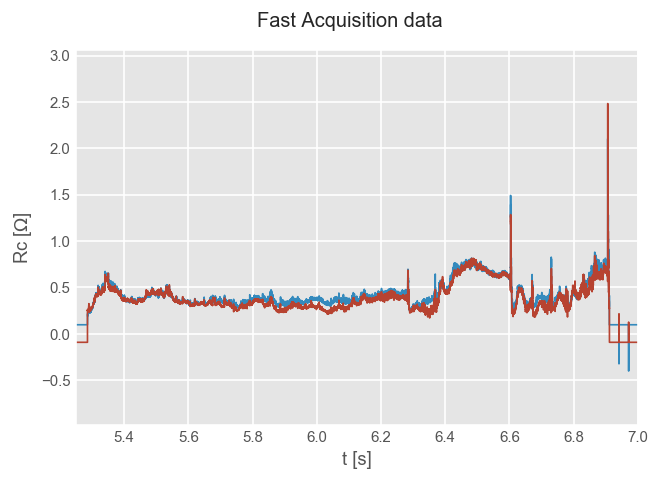

In [252]:
_, t_ini = pw.tsmat(pulse, 'TIGNI:RIGNITRON')
t_ini = t_ini.squeeze()

fig, ax = plt.subplots()
ax.plot(data.Q2_amplitude.index/1e6 + t_ini, RcG)
ax.plot(data.Q2_amplitude.index/1e6 + t_ini, RcD)

ax.set_xlabel('t [s]')
ax.set_ylabel('Rc [$\Omega$]')
ax.set_xlim(5.25, 7)
fig.suptitle('Fast Acquisition data')
#fig.savefig('53693_fast.png', dpi=150)
#ax.set_xlim(38.45, 38.791)

Text(0.5, 1.0, 'Load resilience WEST #53693')

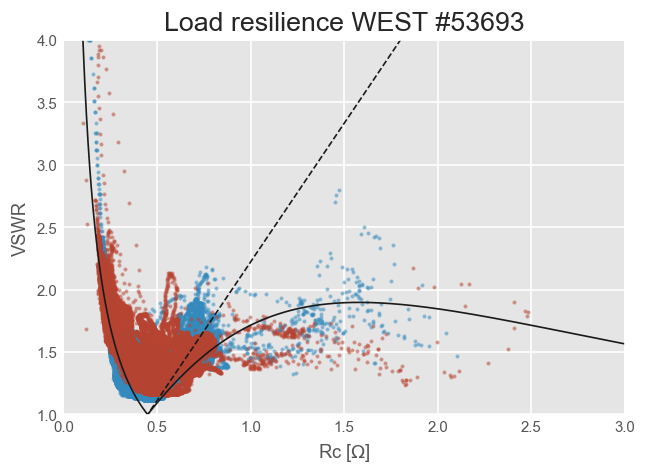

In [256]:
fig, ax = plt.subplots()
ax.plot(RcG, VSWR_G, '.', alpha=0.4)
ax.plot(RcD, VSWR_D, '.', alpha=0.4)
ax.plot(RscanLR, RscanLR/RmNLR, 'k--')
ax.plot(RscanLR, ZtLR/Z0tLR, 'k')
ax.plot(RscanLR, Z0tLR/ZtLR, 'k')   
ax.set_ylabel('VSWR')
ax.set_xlabel('Rc [$\Omega$]')
ax.set_ylim(1, 4)
ax.set_xlim(left=0)
ax.set_title(f'Load resilience WEST #{pulse}')
#fig.savefig('53693_load_resilience.png', dpi=150)

In [36]:
t_start = 5.6
t_stop = 8.0
smooth = True

_Q2_Rc_left, _t_Q2_Rc_left = get_sig(pulse, signals['IC_Rc_Q2_left'], do_smooth=smooth)
_Q2_Rc_right, _t_Q2_Rc_right = get_sig(pulse, signals['IC_Rc_Q2_right'], do_smooth=smooth)
Q2_P_left_fwd, t_Q2_P_left_fwd = get_sig(pulse, signals['IC_P_Q2_left_fwd'], do_smooth=smooth)
Q2_P_left_ref, t_Q2_P_left_red = get_sig(pulse, signals['IC_P_Q2_left_ref'], do_smooth=smooth)
Q2_P_right_fwd, t_Q2_P_right_fwd = get_sig(pulse, signals['IC_P_Q2_right_fwd'], do_smooth=smooth)
Q2_P_right_ref, t_Q2_P_right_red = get_sig(pulse, signals['IC_P_Q2_right_ref'], do_smooth=smooth)

In [37]:
VSWR_Q2_left = (1 + np.sqrt(Q2_P_left_ref/Q2_P_left_fwd))/(1 - np.sqrt(Q2_P_left_ref/Q2_P_left_fwd))
VSWR_Q2_right = (1 + np.sqrt(Q2_P_right_ref/Q2_P_right_fwd))/(1 - np.sqrt(Q2_P_right_ref/Q2_P_right_fwd))

C:\Users\JH218595\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.
C:\Users\JH218595\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


In [38]:
# interpolating Rc on the same time base than Power
Q2_Rc_left = np.interp(t_Q2_P_left_fwd, _t_Q2_Rc_left, _Q2_Rc_left.squeeze())
Q2_Rc_right = np.interp(t_Q2_P_right_fwd, _t_Q2_Rc_right, _Q2_Rc_right.squeeze())

(0, 3.7697266870136423)

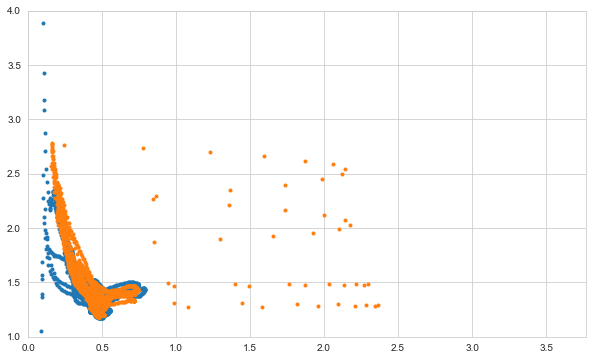

In [41]:
fig, ax = plt.subplots()
ax.plot(Q2_Rc_left, VSWR_Q2_left, '.')
ax.plot(Q2_Rc_right, VSWR_Q2_right, '.')

ax.set_ylim(1, 4)
ax.set_xlim(left=0)

In [ ]:
pulses = [53689]
sigs_general = [signals['Ip'], 
    signals['nl'],
    signals['IC_P_tot'],
    signals['IC_Rc_Q2_avg']]
fig, axes = scope(pulses, sigs_general, do_smooth=False)
axes[-1].set_xlim(5, 10)
axes[0].legend()